In [1]:
from ngsolve import *
from netgen.geom2d import *

import numpy as np
import scipy.linalg
import scipy.sparse as sp

from netgen.occ import *

from helping_functions import *

from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
import csv


In [2]:
# DOMAIN CONSTRUCTION Omega = B1(0)
# Division in 8 subdomains

geo = SplineGeometry()
Points = [(0,-1), (1,-1), (1,0), 
          (1,1), (0,1), (-1,1),
          (-1,0), (-1,-1), (0,0)]

bcs_edge = ["c0", "c1", "c2", "c3", 
            "m0", "m1", "m2", "m3",
            "m4", "m5", "m6", "m7"]

for i, pnt in enumerate(Points):
    geo.AddPoint(*pnt, name = "V" + str(i))

geo.Append(["spline3", 0, 1, 2], leftdomain=1, rightdomain=0, bc="c0")
geo.Append(["spline3", 2, 3, 4], leftdomain=2, rightdomain=0, bc="c1")
geo.Append(["spline3", 4, 5, 6], leftdomain=3, rightdomain=0, bc="c2")
geo.Append(["spline3", 6, 7, 0], leftdomain=4, rightdomain=0, bc="c3")
geo.Append(["line", 0, 2], leftdomain=5, rightdomain=1, bc="m0")
geo.Append(["line", 2, 4], leftdomain=6, rightdomain=2, bc="m1")
geo.Append(["line", 4, 6], leftdomain=7, rightdomain=3, bc="m2")
geo.Append(["line", 6, 0], leftdomain=8, rightdomain=4, bc="m3")

geo.Append(["line", 8, 0], leftdomain=5, rightdomain=8, bc="m4")
geo.Append(["line", 8, 2], leftdomain=6, rightdomain=5, bc="m5")
geo.Append(["line", 8, 4], leftdomain=7, rightdomain=6, bc="m6")
geo.Append(["line", 8, 6], leftdomain=8, rightdomain=7, bc="m7")

# geo = SplineGeometry()
# geo.AddCircle ( (0, 0), r=1, leftdomain=1, rightdomain=0, )
ngmesh = geo.GenerateMesh(maxh= 0.1) #Too much 0.0013




mesh = Mesh(ngmesh)
for i in range(8):
    mesh.ngmesh.SetMaterial(i+1,"om" + str(i))

#Draw(mesh)
print(mesh.nv)
# quit()
print(mesh.GetMaterials())
print(mesh.GetBoundaries())
print(mesh.GetBBoundaries())
# input()

dom_bnd = "c0|c1|c2|c3"



389
('om0', 'om1', 'om2', 'om3', 'om4', 'om5', 'om6', 'om7')
('c0', 'c1', 'c2', 'c3', 'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7')
('V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8')


In [ ]:
#Draw(mesh)

**Helmholtz problem description - Plane wave**

$- div (a \nabla u) - k^2 u  = f$ in $\Omega = B_1(0)$,

$ a \partial_n u - i \omega \beta u = g $ on $\partial \Omega = \Gamma_R$. 


In this example we have:

$a=1$, 

$c=1$, 

$\beta=1$, 

$\omega=2$, 

$k = \omega (0.6,0.8)$,

$f=0$,

$g= -i \left((0.6 x + 0.8 y) + \beta \right) \exp^{-i (0.6 x + 0.8 y)}$

$u_{ex} = \exp^{-i (0.6 x + 0.8 y)}$.

In [3]:
#Problem setting - PLANE WAVE

omega = 1
#CF = CoefficientFunction
kappa = omega
k = kappa * CF((0.6,0.8))
beta = 1
f = 0
u_ex = exp(-1J * (k[0] * x + k[1] * y))
g = -1j * kappa * (k[0] * x + k[1] * y) * u_ex - 1j *beta * u_ex
Du_ex = CF((u_ex.Diff(x), u_ex.Diff(y)))

#Draw(g.real, mesh, "u_ex")
#Draw(g.imag, mesh, "u_ex")


**Helmholtz problem description - Interior source**

$- div (a \nabla u) - k^2 u  = f$ in $\Omega = B_1(0)$,

$ a \partial_n u - i \omega \beta u = g $ on $\partial \Omega = \Gamma_R$. 


In this example we have:

$a=1$, 

$c=1$, 

$\beta=1$, 

$\omega=1$, 

$k = \omega$,

$f=\exp^{(-200 |x-x_c|^2)}$, with $x_c = (1/3,1/3)$,

$g= 0$.

In [ ]:
class Point:
    """ Point class for representing and manipulating x,y coordinates. """

    def __init__(self):
        """ Create a new point at the origin """
        self.x = 0
        self.y = 0

In [ ]:
#Problem setting - INTERIOR SOURCE

omega = 1
kappa = omega
beta = 1
p = (1/3, 1/3)
P = Point()
P.x = 1/3
P.y = 1/3

f = exp(-200 * ((x-P.x)**2 + (y-P.y)**2)) 
g = 0


In [4]:
# Coefficients

order_v = [1,2] # The following error is due to low resolution -> refine mesh
             # Cannot use scipy.linalg.eig for sparse A with k >= N - 1.
    
Bubble_modes = [1,2]#,2,4,8,16,32,64,128]
Edge_modes = [1,2,4]#,32,64,128,256] #[24; 28; : : : ; 3072] #We have 12 edges
max_bm = Bubble_modes[-1]
max_em = Edge_modes[-1]


In [5]:
#Computing the FEM solution /  ground truth solution with higher resolution
V = H1(mesh, order = 3, complex = True)
u, v = V.TnT()


a = BilinearForm(V)
a += grad(u) * grad(v) * dx() 
a += - kappa**2 * u * v * dx()  
a += -1J * omega * beta * u * v * ds(dom_bnd)
a.Assemble()

l = LinearForm(V)
l += f * v * dx(bonus_intorder=10)
l += g * v * ds(dom_bnd,bonus_intorder=10)
l.Assemble()

gfu_ex = GridFunction(V)
ainv = a.mat.Inverse(V.FreeDofs(), inverse = "sparsecholesky")
gfu_ex.vec.data = ainv * l.vec
print("FEM finished")

FEM finished


In [14]:
h1_error = []
dofs =[]
   

for order in order_v:
    print(order)
    V = H1(mesh, order = order, complex = True)
    u, v = V.TnT()


    a = BilinearForm(V)
    a += grad(u) * grad(v) * dx() 
    a += - kappa**2 * u * v * dx()  
    a += -1J * omega * beta * u * v * ds(dom_bnd)
    a.Assemble()

    l = LinearForm(V)
    l += f * v * dx(bonus_intorder=10)
    l += g * v * ds(dom_bnd,bonus_intorder=10)
    l.Assemble()

#     gfu_ex = GridFunction(V)
#     ainv = a.mat.Inverse(V.FreeDofs(), inverse = "sparsecholesky")
#     gfu_ex.vec.data = ainv * l.vec
#     print("FEM finished")


    gfu = GridFunction(V)
    #Computing full basis with max number of modes 
    acms = ACMS(order = order, mesh = mesh, bm = max_bm, em = max_em)
    print(order)

    acms.CalcHarmonicExtensions(kappa = kappa)
    acms.calc_basis()

#     Draw(gfu_ex, mesh, "u_fem")


    for EM in Edge_modes:
            for BM in Bubble_modes:
                #Vc = H1(mesh, order = order, complex = True)
                gfu = GridFunction(V)
                basis = MultiVector(gfu.vec, 0)

                for bv in acms.basis_v:
                    gfu.vec[:] = 0
                    gfu.vec.FV()[:] = bv
                    basis.Append(gfu.vec)

                for e, label in enumerate(mesh.GetBoundaries()):
                    for i in range(EM):
                        #gfu.vec[:] = 0
                        gfu.vec.FV()[:] = acms.basis_e[e * max_em + i]
                        basis.Append(gfu.vec)

                for d, dom in enumerate(mesh.GetMaterials()):
                    for i in range(BM):
                        gfu.vec.FV()[:] = acms.basis_b[d * max_bm + i]
                        basis.Append(gfu.vec)


                num = len(basis)
                dofs.append(num)

                asmall = np.zeros((num, num), dtype=np.complex128)
                asmall = InnerProduct (basis, a.mat * basis, conjugate = False) #Complex


                asmall_np = np.zeros((num, num), dtype=np.complex128)
                asmall_np = asmall.NumPy()

                ainvs_small_np = np.zeros((num, num), dtype=np.complex128)
                ainvs_small_np = np.linalg.inv(asmall_np)

                ainvsmall = np.zeros((num, num), dtype=np.complex128)
                ainvsmall = Matrix(num,num, complex=True)


                for i in range(num):
                    for j in range(num):
                        ainvsmall[i,j] = ainvs_small_np[i,j]

                f_small = []
                usmall = []

                f_small = InnerProduct(basis, l.vec, conjugate=False)

                usmall = ainvsmall * f_small

                gfu.vec[:] = 0.0
                gfu.vec.data = basis * usmall


#                 Draw(gfu-gfu_ex, mesh, "error")

                print("finished_acms")

                #Computing ERROR
#                 grad_uex = Du_ex #When there is an exact solution available
                grad_uex = Grad(gfu_ex) #When we test against the FEM solution
                diff = grad_uex - Grad(gfu)

                h1_error_aux = sqrt( Integrate ( InnerProduct(diff,diff), mesh, order = 15))
#                 print(h1_error_aux.real)

                #Needs to do complex conjugate
                #Draw(gfu, mesh, "u_acms")
                h1_error.append(h1_error_aux.real)


1
1
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
2
2
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms


In [24]:
h1_error_3d = np.reshape(h1_error, (len(order_v), len(Edge_modes), len(Bubble_modes)))
np.save('H1_error', h1_error_3d)
H1_error = np.load('H1_error.npy')
print(H1_error)

[[[0.1432698  0.1432698 ]
  [0.07471112 0.07471112]
  [0.05005774 0.05005774]]

 [[0.13454691 0.13454691]
  [0.05800907 0.05800907]
  [0.01820784 0.01820784]]]


In [7]:
# file = open("MyCSVFile.txt","wt")

# writer = csv.writer(file) #
# for row in h1_tab: 
#     writer.writerow(row) #Writes row by row
# file.close()   

First test for **classical Helmholtz - Tables 5.2 and 5.4**.

Remark. Tables 5.2 and 5.4 can be reproduced if we compare with the explicit solution.


Test carried out with:<br>
Bubble_modes = [1]   (not needed because there is no source term) <br>
Edge_modes = [1,2,4,8,16,32,64]<br>
If the results are compared to the paper, Table 5.2 (second half for $H^1$ error),  we get the same convergence behviour and almost the same numbers (with a difference +/-2 in the second significative number). The saturation point is reached earlier but we are using a coarser mesh than the paper table. It seems that with degree 2 of approximation, we reach the accuracy or the method of order 1 for h=3.4e-4. Moreover, the improvement we get for going to degree 3 is not as significant (should test with finer mesh and more modes, also maybe with higher wavenumber).<br>
<br>


**Table 5.2 - k=1** <br>
**9070** vertices  -  maxh=0.02<br>
**deg=1:** [[0.13599126 0.05923024 0.01892754 0.01008544 0.00911684 0.00904721] <br>
**deg=2:**  [0.13564861 0.05850873 0.0165963  0.00448963 0.00135759 0.0008109]  <br>
**deg=3:**  [0.1356477  0.05850646 0.01658802 0.00445871 0.00125187 0.00061983]]<br>

**36404** vertices - maxh = 0.01 <br>
**deg=1:** [[0.1357756  0.05872428 0.01722265 0.00633276 0.00463325 0.00449471 0.00448552]] <br>
**deg=2:** [[0.13569155 0.05854595 0.01661881 0.00446698 0.0011828  0.00039611 0.00028211 0.00027425]]<br>



Second test for **classical Helmholtz - Tables 5.3 and 5.5**.

Remark. Tables 5.3 and 5.5 can be reproduced if we compare with the reconstructed FEM solution.


Test carried out with:<br>
Bubble_modes = [1]   (not needed because there is no source term) <br>
Edge_modes = [1,2,4,8,16,32]<br>
If the results are compared to the paper, Table 5.3 - 5.5 (second half for $H^1$ error),  <br>
<br>


**Table 5.3 - k=1** <br>
**9070** vertices  -  maxh=0.02<br>
**deg=1:** [[0.13568968 0.05853565 0.01662826 0.00446872 0.0011707  0.00032533]]<br>
**deg=2:**  [0.13564713 0.0585082  0.0165963  0.00449021 0.00135973 0.00081457]]<br>
**deg=3:**  [0.13564678 0.05850724 0.01659262 0.00447638 0.0013136  0.00073667]]<br>

[[0.13599032 0.05923095 0.01893134 0.01009282 0.00912502 0.00905545
  0.1356477  0.05850952 0.01660096 0.00450743 0.00141553 0.00090465]]

**36404** vertices<br>
<br>

First test for **localised interior source - Table 5.6**.

Test carried out with:<br>
Bubble_modes = [1,2,4,8,16,32]<br>
Edge_modes = [1,2,4,8,16,32]<br>
If the results are compared to the paper, Table 5.6 (second half for $H^1$ error), it seems there is a shift of $10^{-2}$ in the results. **WHY?** <br>
The behaviour is the same:<br>
-when increasing the number of bubbles, there is a decrease by a factor of 10 at first, then by a factor of (1.2-1.4) before being halved;<br>
-when increasing the number of bubble modes, and almost no convergence when increasing the number of edge modes. <br>


**9070** vertices   -   maxh= 0.02   <br>
[[0.00442196 0.00424678 0.00423678 0.0042367  0.00423669]<br>
 [0.00328148 0.0030442  0.00303053 0.00303041 0.0030304 ]<br>
 [0.00264233 0.00233963 0.00232186 0.00232171 0.00232171]<br>
 [0.00196496 0.00153383 0.00150645 0.00150621 0.00150621]<br>
 [0.00142522 0.00072262 0.0006625  0.00066196 0.00066195]]<br>


**deg=1:** 

[[0.00458159 0.00442203 0.00424685 0.00423685 0.00423677 0.00423676]<br>
 [0.00458159 0.00442203 0.00424685 0.00423685 0.00423677 0.00423676]<br>
 [0.00349451 0.00328156 0.00304429 0.00303061 0.0030305  0.00303049]<br>
 [0.00290336 0.00264243 0.00233973 0.00232197 0.00232181 0.00232181]<br>
 [0.00230384 0.00196505 0.00153394 0.00150656 0.00150633 0.00150633]<br>
 [0.00186473 0.00142528 0.00072274 0.00066263 0.00066209 0.00066207]]<br>

**deg=2:**

[[0.00459806 0.00443906 0.00426451 0.00425455 0.00425447 0.00425447]
 [0.00459806 0.00443906 0.00426451 0.00425455 0.00425447 0.00425447]
 [0.00351048 0.00329852 0.00306248 0.00304888 0.00304876 0.00304876]
 [0.00291797 0.00265841 0.00235764 0.00234002 0.00233986 0.00233986]
 [0.00231446 0.00197741 0.00154955 0.00152246 0.00152223 0.00152222]
 [0.00186914 0.00143095 0.00073343 0.00067428 0.00067375 0.00067374]]




Test carried out with:<br>
Bubble_modes = [2,4,8,16,32,64,128]<br>
Edge_modes = [2,4,8,16,32,64]<br>

**36404** vertices  -   maxh= 0.01 <br>
 [[4.43480410e-03 4.26011474e-03 4.25014758e-03 4.25006290e-03  4.25006089e-03 4.25006076e-03]<br>
 [3.29424319e-03 3.05791780e-03 3.04429565e-03 3.04417748e-03  3.04417466e-03 3.04417447e-03]<br>
 [2.65429756e-03 2.35307169e-03 2.33540290e-03 2.33524892e-03  2.33524525e-03 2.33524501e-03]<br>
 [1.97422424e-03 1.54558483e-03 1.51840794e-03 1.51817559e-03  1.51816993e-03 1.51816956e-03]<br>
 [1.42950812e-03 7.30846476e-04 6.71437969e-04 6.70904173e-04  6.70891381e-04 6.70890539e-04]<br>
 [1.27328091e-03 3.34645982e-04 1.69477230e-04 1.67358749e-04  1.67307485e-04 1.67304109e-04]<br>
 [1.26234614e-03 2.90246963e-04 3.12063951e-05 1.61222779e-05  1.55808742e-05 1.55445727e-05]]<br>
 
 
 
 
 **deg=1**<br>
 [[4.59394958e-03 4.43480924e-03 4.26012003e-03 4.25015288e-03 4.25006821e-03 4.25006619e-03 4.25006606e-03]<br>
 [4.59394958e-03 4.43480923e-03 4.26012003e-03 4.25015288e-03  4.25006821e-03 4.25006619e-03 4.25006606e-03]<br>
 [3.50646252e-03 3.29424915e-03 3.05792416e-03 3.04430203e-03  3.04418386e-03 3.04418104e-03 3.04418085e-03]<br>
 [2.91422025e-03 2.65430401e-03 2.35307887e-03 2.33541013e-03  2.33525616e-03 2.33525248e-03 2.33525224e-03]<br>
 [2.31173348e-03 1.97423047e-03 1.54559266e-03 1.51841590e-03  1.51818355e-03 1.51817790e-03 1.51817753e-03]<br>
 [1.86803102e-03 1.42951217e-03 7.30854130e-04 6.71446285e-04  6.70912497e-04 6.70899705e-04 6.70898862e-04]<br>
 [1.75140083e-03 1.27328180e-03 3.34648767e-04 1.69482671e-04  1.67364259e-04 1.67312997e-04 1.67309620e-04]<br>
 [1.74346498e-03 1.26234632e-03 2.90247069e-04 3.12070683e-05  1.61235771e-05 1.55822185e-05 1.55459201e-05]]<br>
 
 
 **deg=2**<br>
 [[4.59807863e-03 4.43908036e-03 4.26454921e-03 4.25459291e-03  4.25450837e-03 4.25450634e-03 4.25450620e-03]<br>
 [4.59807863e-03 4.43908036e-03 4.26454921e-03 4.25459291e-03  4.25450837e-03 4.25450634e-03 4.25450620e-03]<br>
 [3.51050902e-03 3.29854680e-03 3.06253295e-03 3.04893235e-03  3.04881442e-03 3.04881158e-03 3.04881139e-03]<br>
 [2.91799572e-03 2.65843594e-03 2.35770958e-03 2.34007714e-03  2.33992355e-03 2.33991985e-03 2.33991961e-03]<br>
 [2.31447681e-03 1.97742567e-03 1.54962709e-03 1.52252399e-03  1.52229240e-03 1.52228671e-03 1.52228633e-03]<br>
 [1.86912891e-03 1.43092453e-03 7.33516335e-04 6.74346626e-04  6.73815391e-04 6.73802539e-04 6.73801674e-04]<br>
 [1.75157534e-03 1.27349675e-03 3.35256719e-04 1.70695051e-04  1.68592971e-04 1.68541623e-04 1.68538166e-04]<br>
 [1.74352402e-03 1.26240259e-03 2.90249897e-04 3.13147644e-05  1.63422593e-05 1.58034778e-05 1.57665645e-05]]<br>
 
 **WHY** there is a slight increase in the error when we refine the mesh and if we increase the polynomial degree?
 
 
 Fixed because we compute on a proper ground truth FEM solution.

In [25]:
plot_error=1

In [27]:
if plot_error==1:
    h1_error = np.reshape(h1_error, (len(order_v)*len(Edge_modes), len(Bubble_modes)))
    dofs = np.reshape(dofs, (len(order_v)*len(Edge_modes), len(Bubble_modes)))

Text(0.5, 0, 'Edge modes')

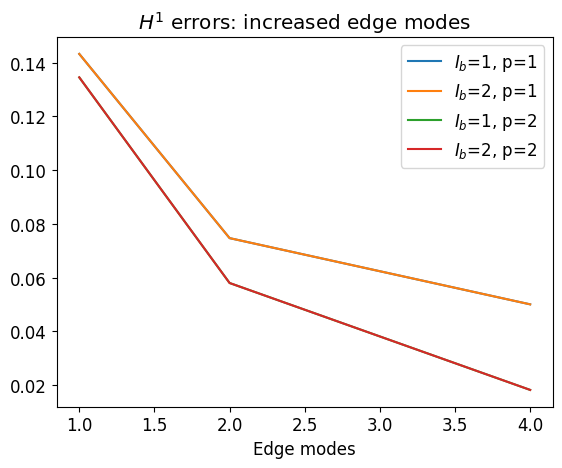

In [28]:
## PLOT ERROR with increased EDGE modes for different DEGREES of approximation
plt.rcParams.update({'font.size':12})
for d in range(len(order_v)):
    for i in range(len(Bubble_modes)):
        plt.plot(Edge_modes, h1_error[d*len(Edge_modes) : d*len(Edge_modes) + len(Edge_modes),i], label=('$I_b$=%i, p=%i' %(Bubble_modes[i],order_v[d])))
plt.title('$H^1$ errors: increased edge modes')
plt.legend()
plt.xlabel('Edge modes')

In [ ]:
## PLOT ERROR with increased BUBBLE modes for different DEGREES of approximation
plt.rcParams.update({'font.size':15})
for d in range(len(order_v)):
    for i in range(len(Edge_modes)):
        plt.plot(Bubble_modes, h1_error[d*len(Edge_modes) + i,:], label=('$I_e$=%i, p=%i' %(Edge_modes[i],order_v[d])))
plt.title('$H^1$ errors: increased bubbles')
plt.legend()
plt.xlabel('Bubbles')